In [11]:
import pickle

import numpyro
import numpyro.handlers as handlers
import jax.numpy as jnp
import jax
from numpyro.infer import Predictive

from src.models.M2VAE import M2VAE
from src.models.encoder_decoder import MNISTEncoder, MNISTDecoder, CIFAR10Encoder, CIFAR10Decoder

import matplotlib.pyplot as plt

In [12]:
# Set up random seed
seed = 42

# DATASET
dataset_name = "MNIST" # use "CIFAR10"

encoder_class = MNISTEncoder if dataset_name=="MNIST" else CIFAR10Encoder
decoder_class = MNISTDecoder if dataset_name=="MNIST" else CIFAR10Decoder
distribution = "bernoulli" if dataset_name=="MNIST" else "laplace"
img_shape = (1, 28, 28, 1)
scale_factor = 1.

In [13]:
m2_vae = M2VAE(encoder_class, 
               decoder_class, 
               10, 
               50, 
               img_shape, 
               scale_factor=scale_factor, 
               distribution=distribution
)

In [14]:
with open("./model_weights/m2MNIST.pkl", 'rb') as file:
    params=pickle.load(file)

In [27]:
xs = jnp.zeros((10, 28, 28, 1))
ys = jnp.array([3 for _ in range(10)])

In [28]:
predictive = Predictive(m2_vae.model_supervised, params=params, num_samples=1 ,return_sites=["loc"])

# Generate predictions
rng_key = jax.random.PRNGKey(0)  # Use an appropriate random key
predictions = predictive(rng_key, xs, ys)

# Extract the 'loc'
loc = predictions['loc']

# Now loc contains the values you're interested in
print(loc.shape)

(1, 10, 28, 28, 1)


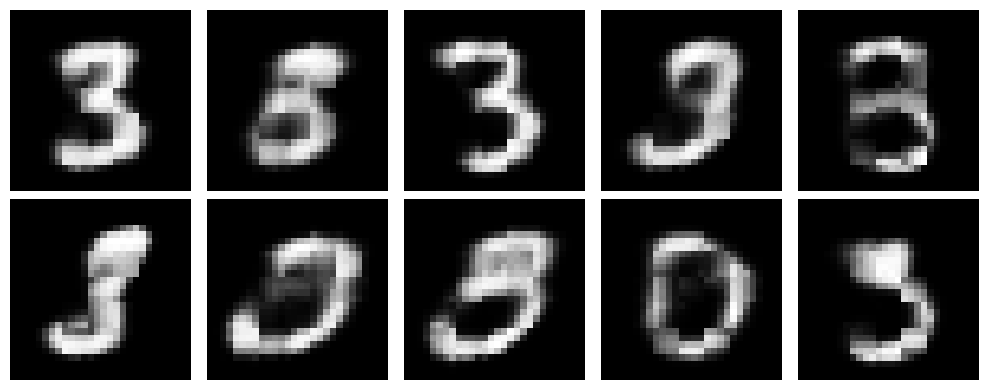

In [29]:
# Set the number of rows and columns for the plot grid
n_rows = 2
n_cols = 5

# Create a figure with subplots
plt.figure(figsize=(n_cols * 2, n_rows * 2))
for i in range(n_rows * n_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    # Select the i-th image and reshape it to 28x28
    image = loc[0, i].reshape(28, 28)
    plt.imshow(image, cmap='gray')  # cmap='gray' is for grayscale
    plt.axis('off')  # Turn off the axis labels

# Adjust layout and show the plot
plt.tight_layout()
plt.show()